# Markov Chain Monte Carlo (MCMC) Sampling: 
---
[Toward Data Science: Monte Carlo Markov Chain (MCMC), Exlplained](https://towardsdatascience.com/monte-carlo-markov-chain-mcmc-explained-94e3a6c8de11)
- about drawing samples from a given distribution: *estimating using randomness*
- **Independent Samples:** averages over samples can be used as unbiased estimators of expected values of parameters in the distribtuion 
    - *Discrete Samples:*
        - *law of large numbers:* growing sample base, fraction of an instance corresponds to its probability 
    - *Continuous Samples:*
        - analogous reasoning applies to a given region of the sample space 
- **Practical Challenge:** ensuring independent sampling because the distribution is *unknown*
    - *dependent samples* can still be unbiased (tend to increase estimate's variance)
    - more smples will be needed for a more precise estimate 


#### Sampling from a Multivariate Distribution is Computationally Demanding: number of *states* increases **exponentially** with the number of *dimensions*

#### [Stochastic:](https://en.wikipedia.org/wiki/Stochastic)
- modeling approach for a random probability distribution 
- means "aim" or "guess" in greek
- *Stochastic Process* -> *Random Process*

## Monte Carlo Methods:
---
- Rely on repeated random sampling to approximate results (memoryless)
- may be determinisitc -> do not permit an exact analytical solution 
- **Identify** and **Explore** regions of the *posterior* that concentrate significant probability density 
    - converges when it consistently moves through nearby high-probability states of the posterior where acceptance rates increase 
    - *Challenge*: balance need for random exploration withthe risk of reducing the acceptance rate 
- developed during Manhattan Project for the Atomic Bomb

> ## Monte Carlo Method applied to a Markov Chain Process: 
> 1. Start at *Current* Position
> 2. Draw a *New* Position from a *Proposal Distribution*
> 3. Evaluate the Probability of the Nw Position in Light of *Data* and *Prior Positions*
>       - if sufficiently likely -> move to new position 
>       - otherwise -> remain at current position 
> 4. *Repeat from *Step 1**
> 5. After a Given Number of Iterations, Return all Accepted Positions 

- *Initial Steps* are typically more reflective of the starting position than the posterior
    - typically discarded as: *Burn-In *Samples**
    - should forget about initial starting point after a certain number of iterations 
- *Remaining Samples* are called the **TRACE** of the process
    - *law of large numbers*: relative frequency of samples approximates the posterior and can be used to compute expected values 

### Import Libraries

In [1]:
import pandas as pd 
import numpy as np
import datetime as dt 

In [2]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt 
import seaborn as sns 

from matplotlib.axis import Axis

# [Example](https://towardsdatascience.com/markov-chain-monte-carlo-in-python-44f7e609be98)
---
[GitHub](https://github.com/WillKoehrsen/ai-projects/blob/master/markov_chain_monte_carlo/markov_chain_monte_carlo.ipynb)

- Use sleep data to create a model that specifies the posterior probability of sleep as a function of time 
- time = continuous variable 
    - unable to specify the entire posterior distribution 
    - turn to methods that approximate a distribution (aka MCMC)

### [How To Analyze Apple Health Data With Python](https://www.python-engineer.com/posts/apple-health-data-python/)
### [Analyse your Health with Python and Apple Health](https://towardsdatascience.com/analyse-your-health-with-python-and-apple-health-11c12894aae2)

# Apple Health Data XML -> CSV
--- 


### Pandas DF to CSV 

In [3]:
df = pd.read_csv('data/steps_distance.csv')
df.set_index('endDate', inplace=True)
df

,StepCount,DistanceWalkingRunning
endDate,,
2021-09-10,3246.0,1.309123
2021-09-11,10003.0,4.154720
2021-09-12,4812.0,2.097997
2021-09-13,4672.0,1.776384
2021-09-14,5914.0,2.324539
...,...,...
2022-12-03,12476.0,4.832174
2022-12-04,3428.0,1.365090
2022-12-05,16428.0,6.891993


# Pull CSV Apple Health Data 
--- 

In [4]:
# External Data
# Daily Difference in Walking 
df['StepDelta'] = df['StepCount'].diff()
df['DistanceDelta'] = df['DistanceWalkingRunning'].diff()

#Synthetic Variables: Not Obtained by Direct Measurement 
# Haddie vs. No Haddie 
df['Haddie'] = 0 
df.loc[(df.index > '20220323'), 'Haddie'] = 1

# Out of Town vs. NYC 
df['OutOfTown'] = 0 
df.loc[(df.index > '20220905') & (df.index < '20220910'), 'OutOfTown'] = 1 #Bermuda
df.loc[(df.index > '20220712') & (df.index < '20220716'), 'OutOfTown'] = 1 #Dallas-July
df.loc[(df.index > '20220721') & (df.index < '20220725'), 'OutOfTown'] = 1 #PalmBeach-July
df.loc[(df.index > '20220519') & (df.index < '20220525'), 'OutOfTown'] = 1 #EDCVegas

# Days Above 10,000 Steps
df['Above10k'] = 0 
df.loc[(df.StepCount > 10000), 'Above10k'] = 1 


df

,StepCount,DistanceWalkingRunning,StepDelta,DistanceDelta,Haddie,OutOfTown,Above10k
endDate,,,,,,,
2021-09-10,3246.0,1.309123,NaN,NaN,0,0,0
2021-09-11,10003.0,4.154720,6757.0,2.845597,0,0,1
2021-09-12,4812.0,2.097997,-5191.0,-2.056723,0,0,0
2021-09-13,4672.0,1.776384,-140.0,-0.321613,0,0,0
2021-09-14,5914.0,2.324539,1242.0,0.548155,0,0,0
...,...,...,...,...,...,...,...
2022-12-03,12476.0,4.832174,3192.0,1.057401,0,0,1
2022-12-04,3428.0,1.365090,-9048.0,-3.467084,0,0,0
2022-12-05,16428.0,6.891993,13000.0,5.526902,0,0,1


### Split Dataframe 

In [5]:
fall_2021 = df.loc[(df.index > '2021-09-08') & (df.index < '2022-01-01')]
jan_may_22 = df.loc[(df.index > '2021-12-31') & (df.index < '2022-06-01')]
june_oct_22 = df.loc[(df.index > '2022-06-01') & (df.index < '2022-11-01')]

fall_2021 = fall_2021.set_index(pd.DatetimeIndex(fall_2021.index))
jan_may_22 = jan_may_22.set_index(pd.DatetimeIndex(jan_may_22.index))
june_oct_22 = june_oct_22.set_index(pd.DatetimeIndex(june_oct_22.index))


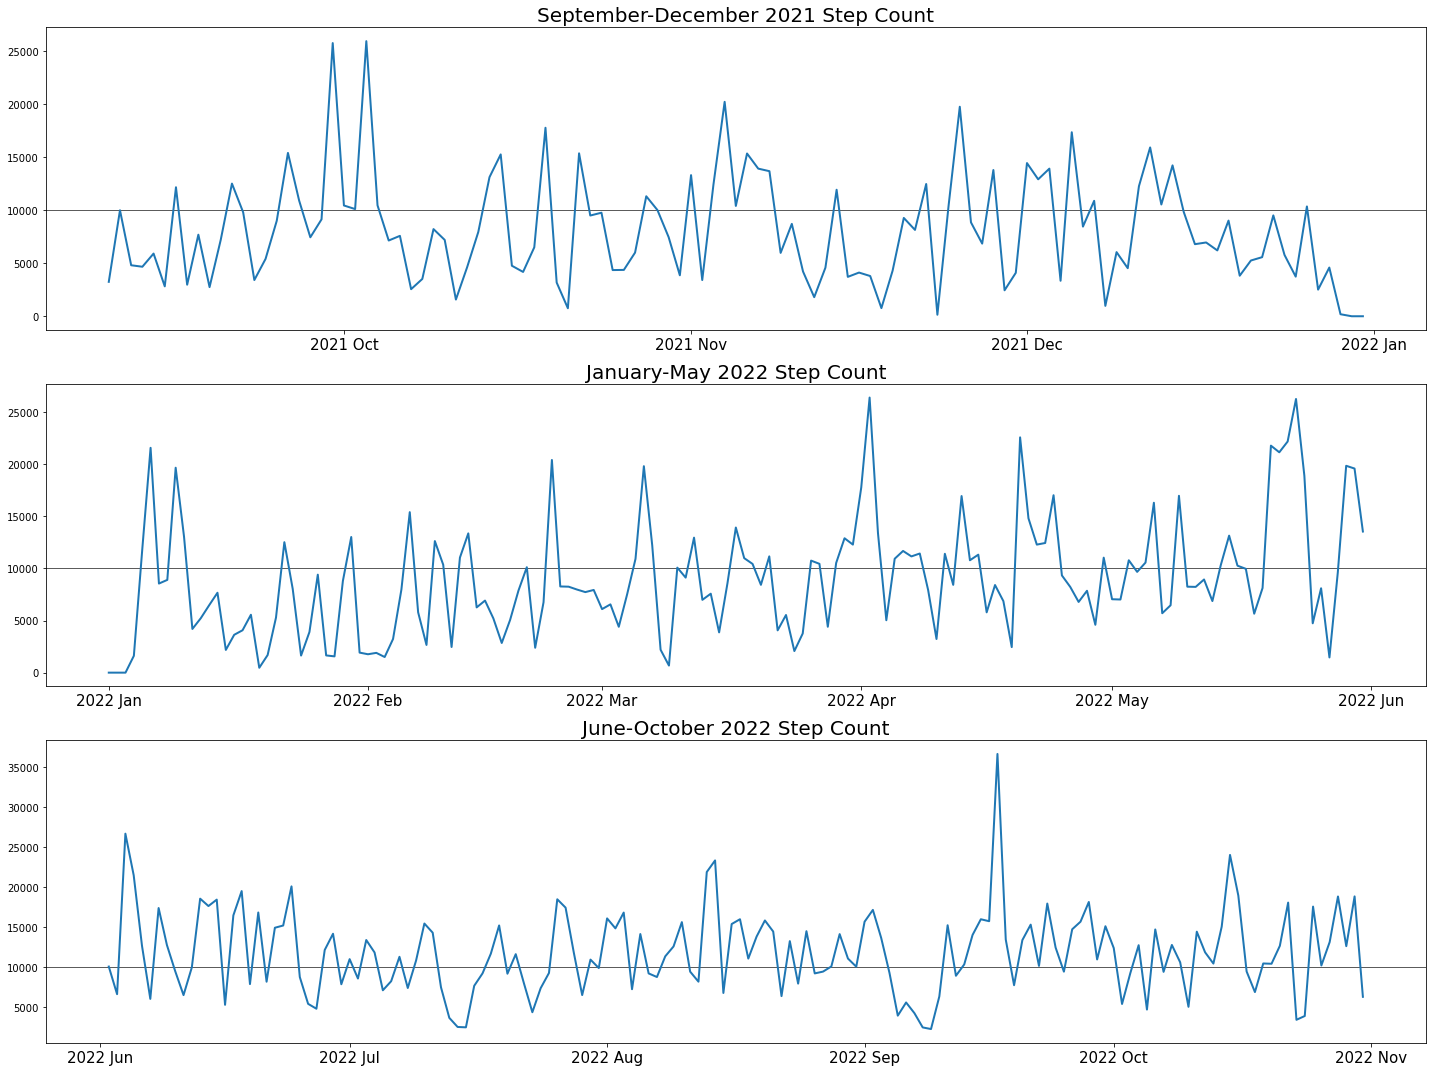

In [6]:
fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(20,15))

axes[0].axhline(y=10000, color='black', linewidth=0.8, alpha=0.8)
axes[0].plot(fall_2021.StepCount, linewidth=2)

axes[0].set_title("September-December 2021 Step Count", fontsize=20)
Axis.set_major_locator(axes[0].xaxis, mdates.MonthLocator())
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y %b'))
axes[0].tick_params(axis='x', which='major', labelsize=15)

axes[1].axhline(y=10000, color='black', linewidth=0.8, alpha=0.8)
axes[1].plot(jan_may_22.StepCount, linewidth=2)

axes[1].set_title("January-May 2022 Step Count", fontsize=20)
Axis.set_major_locator(axes[1].xaxis, mdates.MonthLocator())
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y %b'))
axes[1].tick_params(axis='x', which='major', labelsize=15)

axes[2].axhline(y=10000, color='black', linewidth=0.8, alpha=0.8)
axes[2].plot(june_oct_22.StepCount, linewidth=2)

axes[2].set_title("June-October 2022 Step Count", fontsize=20)
Axis.set_major_locator(axes[2].xaxis, mdates.MonthLocator())
axes[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y %b'))
axes[2].tick_params(axis='x', which='major', labelsize=15)


plt.tight_layout()
plt.show()


# Intraday Step Count Data 
---

In [22]:
import pandas as pd
import datetime as dt 
import numpy as np

import matplotlib.pyplot as plt 

from datetime import datetime

### Import `.csv` Data + Handle Datetime Object

In [44]:
# Read CSV Data and Parse Datetime
#df = pd.read_csv('data/step_count_intraday.csv', parse_dates=[0])
df = pd.read_csv('data/step_count_intraday.csv')

# setup datetime to analyze time range specific data 
df['date'] = pd.to_datetime(df['date'])
oct_2021 = df.loc[(df['date'] > '2021-09-30') & (df['date'] < '2021-11-01')]
oct_2022 = df.loc[(df['date'] > '2022-09-30') & (df['date'] < '2022-11-01')]

#organize data for box plots 
box_oct_2022 = oct_2022.groupby(['time'])['value'].apply(list)
box_oct_2021 = oct_2021.groupby(['time'])['value'].apply(list)

mean_oct_2022 = oct_2022.groupby(['time'])['value'].mean()
mean_oct_2021 = oct_2021.groupby(['time'])['value'].mean()

### Plot Boxplots

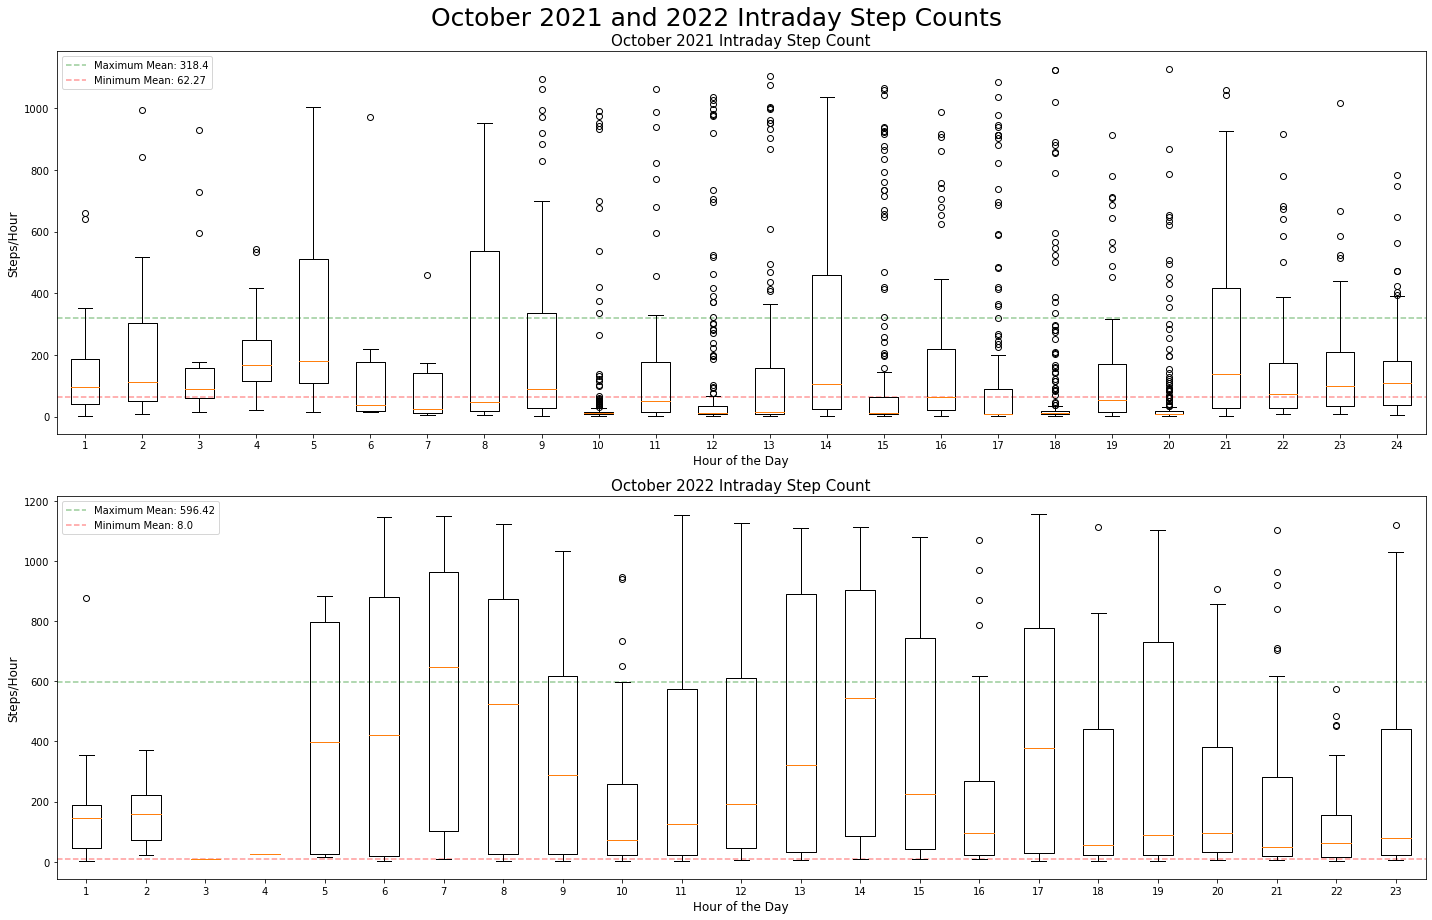

In [43]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20,13))

ax[0].axhline(y=mean_oct_2021.max(), xmin=0, xmax=25, linestyle='--', alpha=0.4, color='green', label="Maximum Mean: {}".format(round(mean_oct_2021.max(),2)))
ax[0].axhline(y=mean_oct_2021.min(), xmin=0, xmax=25, linestyle='--', alpha=0.4, color='red', label="Minimum Mean: {}".format(round(mean_oct_2021.min(),2)))
ax[0].boxplot(box_oct_2021)
ax[0].set_title("October 2021 Intraday Step Count", fontsize=15)
ax[0].set_xlabel("Hour of the Day", fontsize=12)
ax[0].set_ylabel("Steps/Hour", fontsize=12)
ax[0].legend(loc=2)

ax[1].axhline(y=mean_oct_2022.max(), xmin=0, xmax=25, linestyle='--', alpha=0.4, color='green', label="Maximum Mean: {}".format(round(mean_oct_2022.max(),2)))
ax[1].axhline(y=mean_oct_2022.min(), xmin=0, xmax=25, linestyle='--', alpha=0.4, color='red', label="Minimum Mean: {}".format(round(mean_oct_2022.min(),2)))
ax[1].boxplot(box_oct_2022)
ax[1].set_title("October 2022 Intraday Step Count", fontsize=15)
ax[1].set_xlabel("Hour of the Day", fontsize=12)
ax[1].set_ylabel("Steps/Hour", fontsize=12)
ax[1].legend(loc=2)


plt.suptitle("October 2021 and 2022 Intraday Step Counts", fontsize=25)
plt.tight_layout()
plt.show()